In [1]:
%run load_gamma_data.ipynb
%run load_md_data.ipynb

from typing import TYPE_CHECKING

from numpy import float64
from numpy.typing import NDArray

from sqw.typing import Array1D

if TYPE_CHECKING:
    time: Array1D[float64]
    gamma_qtm: Array1D[float64]
    gamma_cls: Array1D[float64]

    q_vals: Array1D[float64]
    omega_md: Array1D[float64]
    sqw_md_stack: NDArray[float64]

Text(0, 0.5, 'Absolute Value of SISF Quantum Correction')

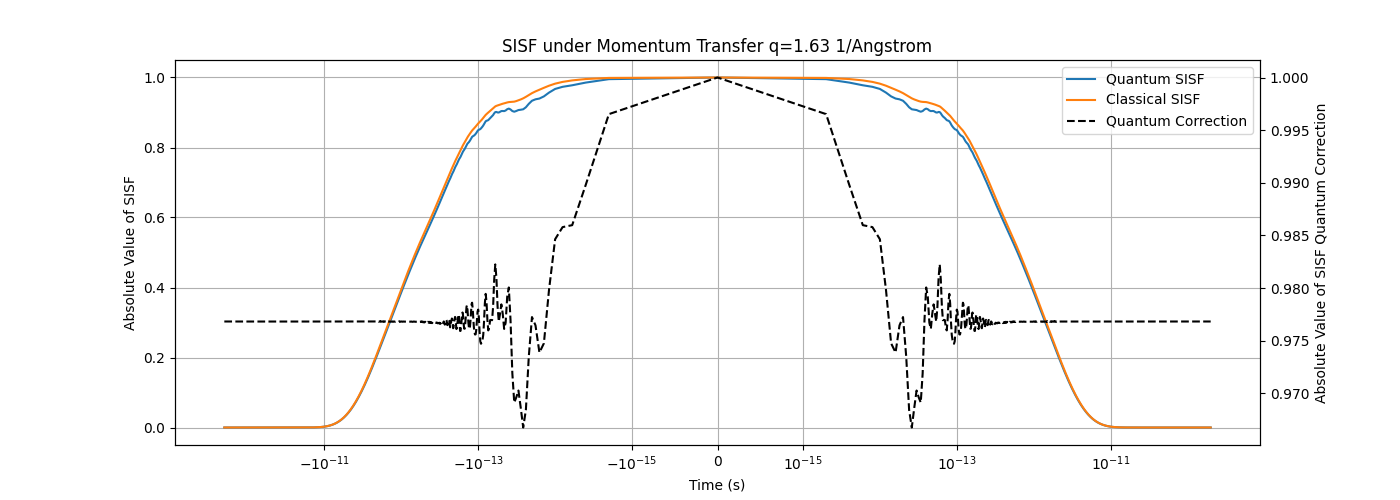

In [2]:
%matplotlib widget
import numpy as np
from matplotlib import pyplot as plt

Q_INDEX = 110  # the index of momentum transfer to be calculated
MOMENTUM_TRANSFER = q_vals[Q_INDEX]  # in unit of Angstrom^-1


def ga_sisf(gamma: Array1D[float64], q: float) -> Array1D[float64]:
    """Get the Self-Intermediate Scattering Function (SISF) from the width
    function under Gaussian approximation."""
    return np.exp(-0.5 * q**2 * gamma)


sisf_qtm = ga_sisf(gamma_qtm, MOMENTUM_TRANSFER)
sisf_cls = ga_sisf(gamma_cls, MOMENTUM_TRANSFER)
sisf_qc = ga_sisf(gamma_qtm - gamma_cls, MOMENTUM_TRANSFER)

plt.close("all")
plt.figure(figsize=(14, 5))
line1 = plt.plot(time, np.abs(sisf_qtm), label="Quantum SISF")
line2 = plt.plot(time, sisf_cls, label="Classical SISF")
plt.xscale("symlog", linthresh=1e-15)
plt.xlabel("Time (s)")
plt.ylabel("Absolute Value of SISF")
plt.title(f"SISF under Momentum Transfer q={MOMENTUM_TRANSFER:.2f} 1/Angstrom")
plt.grid()
plt.twinx()
line3 = plt.plot(time, np.abs(sisf_qc), label="Quantum Correction", color="k", ls="--")
plt.legend(line1 + line2 + line3, [line.get_label() for line in line1 + line2 + line3])
plt.ylabel("Absolute Value of SISF Quantum Correction")

Calculating S(q,w) with Gaussian Approximation model (q = 1.63 1/Ang)...
...calculating q = 1.63...
S(q,w) GA result for q = 1.63 calculation completed.


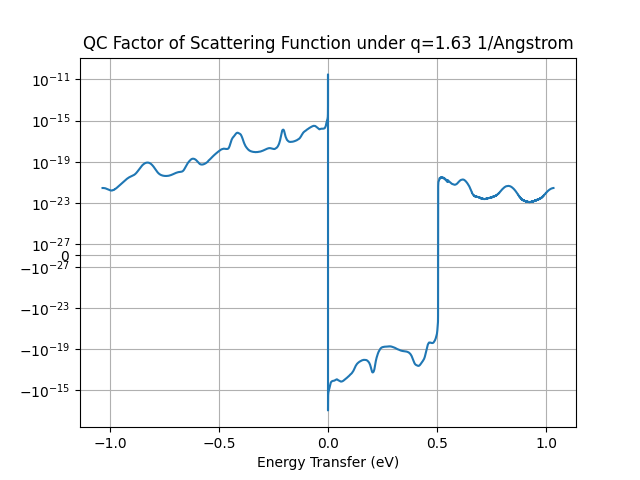

In [3]:
# show the QC factor of scattering function
from sqw import sqw_ga_model
from sqw.consts import HBAR

omega_qc, sqw_qc = sqw_ga_model(MOMENTUM_TRANSFER, time, gamma_qtm - gamma_cls, window=True)

plt.figure()
plt.plot(omega_qc * HBAR, sqw_qc)
plt.xlabel("Energy Transfer (eV)")
plt.title(f"QC Factor of Scattering Function under q={MOMENTUM_TRANSFER:.2f} 1/Angstrom")
plt.yscale("symlog", linthresh=1e-27)
plt.grid()

Calculating S(q,w) with Gaussian Approximation model (q = 1.63 1/Ang)...
S(q,w) GA result for q = 1.63 calculation completed.


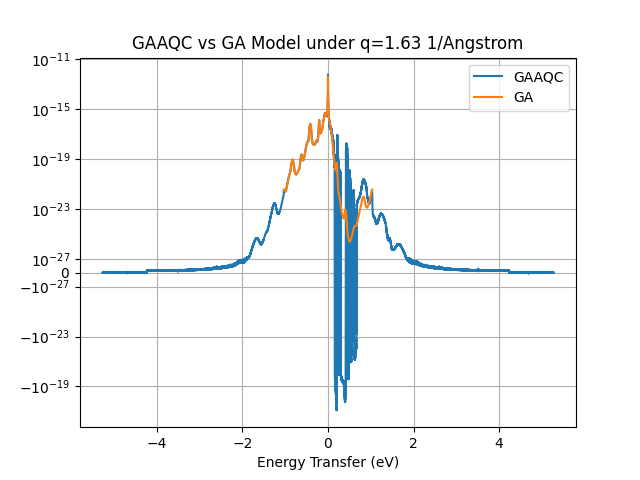

In [7]:
# show the GAAQC model result vs 
from sqw._math import linear_convolve, linear_convolve_x_axis

omega_ga, sqw_ga = sqw_ga_model(MOMENTUM_TRANSFER, time, gamma_qtm)

dw = omega_md[1] - omega_md[0]
omega_qc_aligned = np.linspace(omega_qc[0], omega_qc[-1], int((omega_qc[-1] - omega_qc[0]) / dw) + 1)
sqw_qc_aligned = np.interp(omega_qc_aligned, omega_qc, sqw_qc)

omega_gaaqc = linear_convolve_x_axis(omega_md, omega_qc_aligned)
sqw_gaaqc = linear_convolve(sqw_md_stack[Q_INDEX], sqw_qc_aligned, dw)

plt.figure()
plt.plot(omega_gaaqc * HBAR, sqw_gaaqc, label="GAAQC")
plt.plot(omega_ga * HBAR, sqw_ga, label="GA")
plt.legend()
plt.grid()
plt.xlabel("Energy Transfer (eV)")
plt.title(f"GAAQC vs GA Model under q={MOMENTUM_TRANSFER:.2f} 1/Angstrom")
plt.yscale("symlog", linthresh=1e-27)